In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split

import torcheval.metrics.functional as metrics

import pandas as pd
import numpy as np
from tqdm import tqdm

torch.manual_seed(1000) # set the random seed

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

class SleepDataset(Dataset):
    def __init__(self, hr_file, ecg_file, window_size=30):
        self.df1 = pd.read_csv(hr_file)
        self.df2 = pd.read_csv(ecg_file)
        self.window_size = window_size

        self.freq1 = 1
        self.freq2 = 256


    def __len__(self):
        len1 = len(self.df1)/(self.freq1*self.window_size)
        len2 = len(self.df2)/(self.freq2*self.window_size)
        #should be the same but just in case
        return round(min(len1,len2))

    def __getitem__(self, idx):
        start_window1 = self.window_size*idx*self.freq1
        start_window2 = self.window_size*idx*self.freq2
        # Extract heart rate data points and label for the current window
        hr = self.df1['heart_rate'].iloc[start_window1:start_window1+self.window_size*self.freq1].values
        act = self.df1['activity_count'].iloc[start_window1:start_window1+self.window_size*self.freq1].values
        labels = self.df1['psg_status'].iloc[start_window1]
        #optional: combine labels
        #labels = np.where(labels != 0, 1, labels)
        if labels in [2,3]:
            labels = 2
        elif labels in [4,5]:
            labels = 3



        ecg = self.df2['ECG'].iloc[start_window2:start_window2+self.window_size*self.freq2].values

        # Convert to PyTorch tensors
        hr = torch.tensor(hr, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        labels = torch.tensor(labels, dtype=torch.long)
        ecg = torch.tensor(ecg, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        act = torch.tensor(act, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0



        return hr, ecg, act, labels




In [14]:
# based on: https://github.com/akaraspt/tinysleepnet

#takes in ECG and either activity or heart rate data

class SleepNet(nn.Module):
    def __init__(self):
        super(SleepNet,self).__init__()
        self.pool1 = nn.MaxPool1d(8, 8) #kernel_size, stride
        self.pool2 = nn.MaxPool1d(4, 4) #kernel_size, stride

        self.conv1 = nn.Conv1d(1, 128, 8) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv1d(128, 128, 8) #in_channels, out_chanels, kernel_size

        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(128,128)


        self.fc1 = nn.Linear(29952, 16)

        self.fc2 = nn.Linear(30, 16)
        self.fc3 = nn.Linear(32, 4)



    def forward(self, ecg, hr):

        ecg = self.pool1(ecg)
        ecg = self.dropout(ecg)
        ecg = F.relu(self.conv1(ecg))
        ecg = F.relu(self.conv2(ecg))
        ecg = self.pool2(F.relu(self.conv2(ecg)))
        ecg = self.dropout(ecg)


        # Transpose dimensions for LSTM input
        ecg = ecg.permute(2, 0, 1)  # Shape: [seq_len, batch_size, input_size]

        ecg, _ = self.lstm(ecg)
        ecg = self.dropout(ecg)

        #Get size of final layer
        x_dim = ecg.size(0) * ecg.size(2)

        ecg = ecg.view(-1, x_dim) #[batch size, output size]
        ecg = F.relu(self.fc1(ecg)) #[batch size, 16]

        #fully connected layer for HR data
        hr = hr.squeeze(1)
        hr = F.relu(self.fc2(hr))  #[batch size, 16]


        cat = torch.cat((ecg, hr), dim=1)

        cat = self.fc3(cat)
        cat = cat.squeeze(1) # Flatten to [batch_size]

        return cat



In [15]:


#dataset = SleepDataset(r'mesa_preproc/final/subject_0002.csv',r'mesa_preproc/final/subject_0002_ecg.csv')
dataset = SleepDataset('/content/drive/MyDrive/subject_0002.csv','/content/drive/MyDrive/subject_0002_ecg.csv')


# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% of the data for training
val_size = int(0.15 * len(dataset))   # 15% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])






In [18]:


def train(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=1, use_act=False):

    #uses either activity or heart rate data

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = True)


    #calculate class weights (bc unblanced data)
    labels = []

    for batch in train_loader:
        _, _,_, label_batch = batch
        labels.append(label_batch)
    labels = torch.cat(labels, dim=0)

    class_counts = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts.float())
    class_weights /= class_weights.sum()


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        class_weights = class_weights.cuda()
    #############################################



    criterion = nn.CrossEntropyLoss(weight = class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for hr, ecg, act, labels in train_loader:
            optimizer.zero_grad()

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              hr = hr.cuda()
              ecg = ecg.cuda()
              act = act.cuda()
              labels = labels.cuda()
            #############################################

            if use_act:
                out = model(ecg, act)
            else:
                out = model(ecg, hr)

            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * hr.size(0)
            _, predicted = torch.max(out, 1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_samples += hr.size(0)

        # Compute training epoch statistics
        train_loss = running_train_loss / total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for val_hr, val_ecg, val_act, val_labels in val_loader:

                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                    val_hr = val_hr.cuda()
                    val_ecg = val_ecg.cuda()
                    val_act = val_act.cuda()
                    val_labels = val_labels.cuda()
                #############################################
                if use_act:
                    val_out = model(val_ecg, val_act)
                else:
                    val_out = model(val_ecg, val_hr)

                val_loss = criterion(val_out, val_labels)
                running_val_loss += val_loss.item() * val_hr.size(0)

                _, val_predicted = torch.max(val_out, 1)
                correct_val_predictions += (val_predicted == val_labels).sum().item()
                total_val_samples += val_hr.size(0)

        # Compute validation epoch statistics
        val_loss = running_val_loss / total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


Using CUDA
Epoch [1/100], Train Loss: 1.4053, Train Accuracy: 0.2327, Val Loss: 1.3742, Val Accuracy: 0.0844
Epoch [2/100], Train Loss: 1.3891, Train Accuracy: 0.1066, Val Loss: 1.3821, Val Accuracy: 0.2468
Epoch [3/100], Train Loss: 1.3825, Train Accuracy: 0.1177, Val Loss: 1.3787, Val Accuracy: 0.2208
Epoch [4/100], Train Loss: 1.3722, Train Accuracy: 0.1787, Val Loss: 1.3968, Val Accuracy: 0.2143
Epoch [5/100], Train Loss: 1.3780, Train Accuracy: 0.1773, Val Loss: 1.3920, Val Accuracy: 0.3182
Epoch [6/100], Train Loss: 1.3626, Train Accuracy: 0.2839, Val Loss: 1.3852, Val Accuracy: 0.2403
Epoch [7/100], Train Loss: 1.3600, Train Accuracy: 0.4058, Val Loss: 1.3670, Val Accuracy: 0.5714
Epoch [8/100], Train Loss: 1.3569, Train Accuracy: 0.3615, Val Loss: 1.3709, Val Accuracy: 0.2727
Epoch [9/100], Train Loss: 1.3525, Train Accuracy: 0.5582, Val Loss: 1.3672, Val Accuracy: 0.6104
Epoch [10/100], Train Loss: 1.3425, Train Accuracy: 0.6385, Val Loss: 1.3713, Val Accuracy: 0.5195
Epoch [1

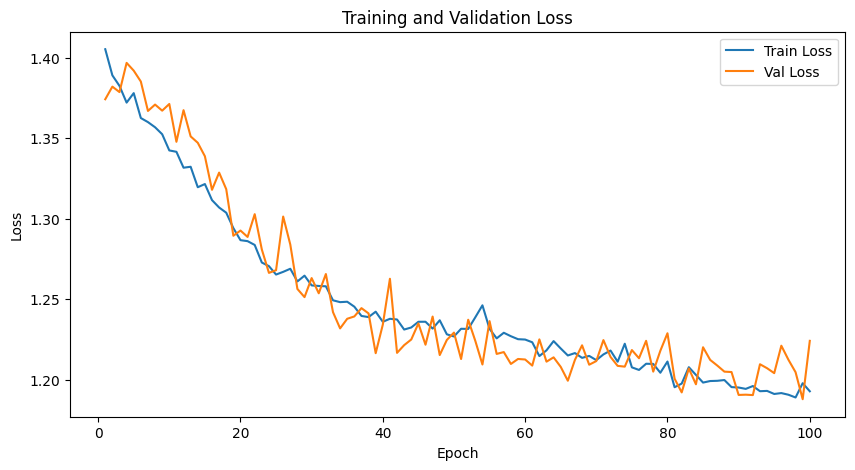

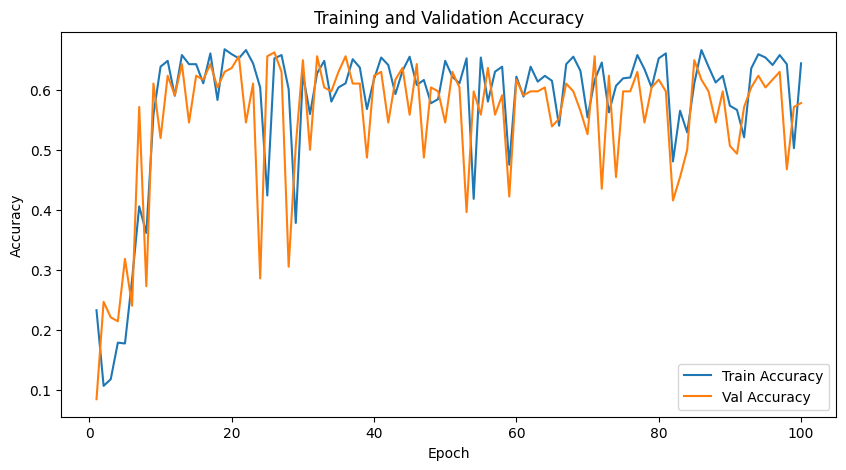

In [24]:
#model using heart rate data
model = SleepNet()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=64,learning_rate = 0.001, num_epochs=100)


Using CUDA
Epoch [1/50], Train Loss: 1.4029, Train Accuracy: 0.2161, Val Loss: 1.3749, Val Accuracy: 0.1948
Epoch [2/50], Train Loss: 1.3897, Train Accuracy: 0.4834, Val Loss: 1.4018, Val Accuracy: 0.5844
Epoch [3/50], Train Loss: 1.3855, Train Accuracy: 0.5983, Val Loss: 1.3882, Val Accuracy: 0.6429
Epoch [4/50], Train Loss: 1.3772, Train Accuracy: 0.6662, Val Loss: 1.3834, Val Accuracy: 0.6429
Epoch [5/50], Train Loss: 1.3766, Train Accuracy: 0.6454, Val Loss: 1.3819, Val Accuracy: 0.5000
Epoch [6/50], Train Loss: 1.3724, Train Accuracy: 0.5111, Val Loss: 1.3783, Val Accuracy: 0.3636
Epoch [7/50], Train Loss: 1.3699, Train Accuracy: 0.3573, Val Loss: 1.3808, Val Accuracy: 0.2792
Epoch [8/50], Train Loss: 1.3664, Train Accuracy: 0.2825, Val Loss: 1.3742, Val Accuracy: 0.2532
Epoch [9/50], Train Loss: 1.3642, Train Accuracy: 0.2576, Val Loss: 1.3725, Val Accuracy: 0.2597
Epoch [10/50], Train Loss: 1.3605, Train Accuracy: 0.2922, Val Loss: 1.3763, Val Accuracy: 0.3312
Epoch [11/50], Tra

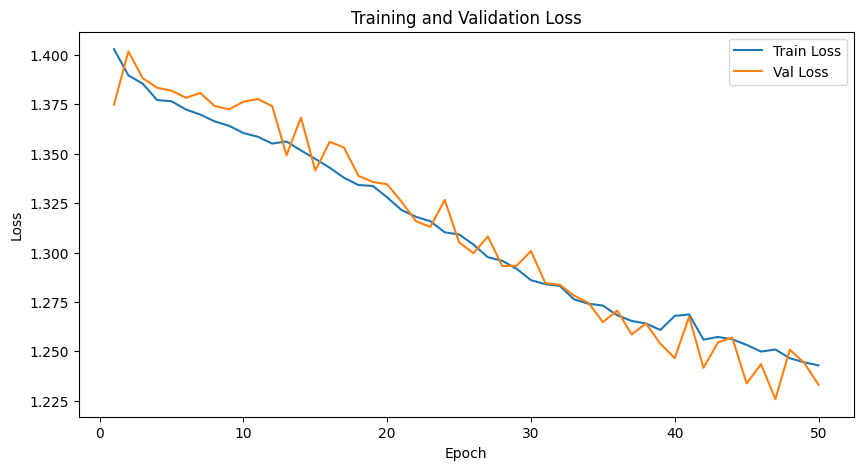

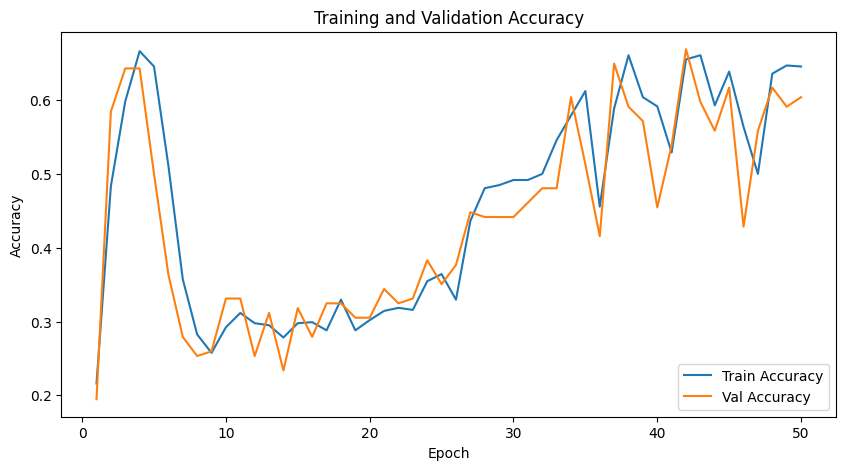

In [25]:
#model using heart rate data
model = SleepNet()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=128,learning_rate = 0.001, num_epochs=50)

Using CUDA
Epoch [1/100], Train Loss: 1.3969, Train Accuracy: 0.0873, Val Loss: 1.3696, Val Accuracy: 0.0909
Epoch [2/100], Train Loss: 1.3858, Train Accuracy: 0.1053, Val Loss: 1.3674, Val Accuracy: 0.0779
Epoch [3/100], Train Loss: 1.3825, Train Accuracy: 0.0443, Val Loss: 1.3657, Val Accuracy: 0.0844
Epoch [4/100], Train Loss: 1.3811, Train Accuracy: 0.0471, Val Loss: 1.3661, Val Accuracy: 0.0909
Epoch [5/100], Train Loss: 1.3801, Train Accuracy: 0.0873, Val Loss: 1.3694, Val Accuracy: 0.2078
Epoch [6/100], Train Loss: 1.3778, Train Accuracy: 0.0789, Val Loss: 1.3666, Val Accuracy: 0.0974
Epoch [7/100], Train Loss: 1.3749, Train Accuracy: 0.0900, Val Loss: 1.3663, Val Accuracy: 0.1948
Epoch [8/100], Train Loss: 1.3740, Train Accuracy: 0.1731, Val Loss: 1.3642, Val Accuracy: 0.2403
Epoch [9/100], Train Loss: 1.3715, Train Accuracy: 0.2299, Val Loss: 1.3660, Val Accuracy: 0.2468
Epoch [10/100], Train Loss: 1.3712, Train Accuracy: 0.2992, Val Loss: 1.3669, Val Accuracy: 0.2922
Epoch [1

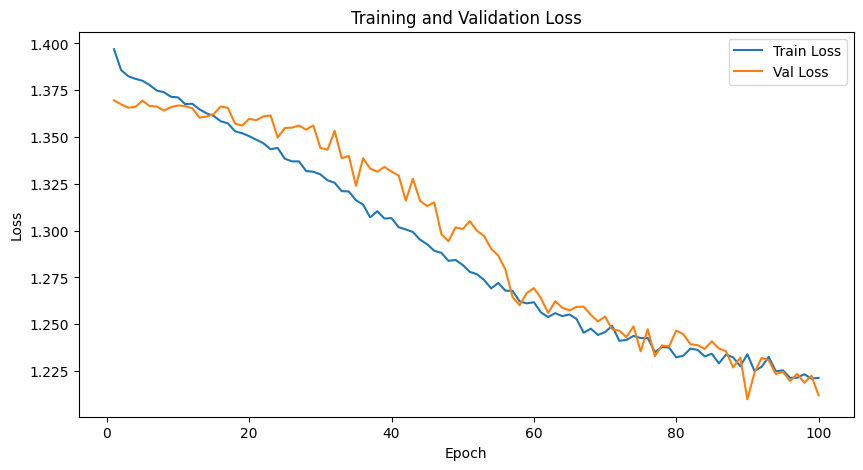

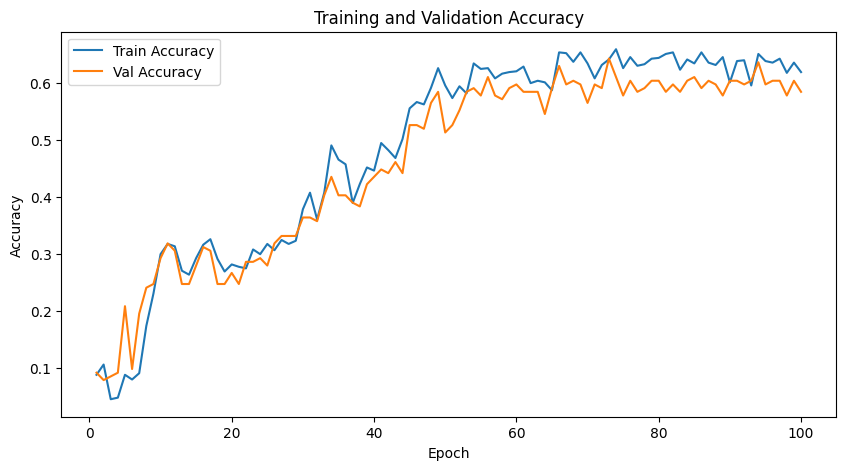

In [26]:
#model using heart rate data
model = SleepNet()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=64,learning_rate = 0.0005, num_epochs=100)

Using CUDA
Epoch [1/50], Train Loss: 2.6731, Train Accuracy: 0.1787, Val Loss: 1.3129, Val Accuracy: 0.2403
Epoch [2/50], Train Loss: 1.3105, Train Accuracy: 0.2770, Val Loss: 1.3753, Val Accuracy: 0.2403
Epoch [3/50], Train Loss: 1.2938, Train Accuracy: 0.3102, Val Loss: 1.4014, Val Accuracy: 0.6364
Epoch [4/50], Train Loss: 1.2777, Train Accuracy: 0.6053, Val Loss: 1.3909, Val Accuracy: 0.6364
Epoch [5/50], Train Loss: 1.2837, Train Accuracy: 0.2742, Val Loss: 1.3582, Val Accuracy: 0.2403
Epoch [6/50], Train Loss: 1.2643, Train Accuracy: 0.1911, Val Loss: 1.3571, Val Accuracy: 0.2468
Epoch [7/50], Train Loss: 1.2635, Train Accuracy: 0.1898, Val Loss: 1.2614, Val Accuracy: 0.2468
Epoch [8/50], Train Loss: 1.2617, Train Accuracy: 0.1953, Val Loss: 1.3266, Val Accuracy: 0.2468
Epoch [9/50], Train Loss: 1.2578, Train Accuracy: 0.2978, Val Loss: 1.3352, Val Accuracy: 0.3377
Epoch [10/50], Train Loss: 1.2507, Train Accuracy: 0.3006, Val Loss: 1.3434, Val Accuracy: 0.3312
Epoch [11/50], Tra

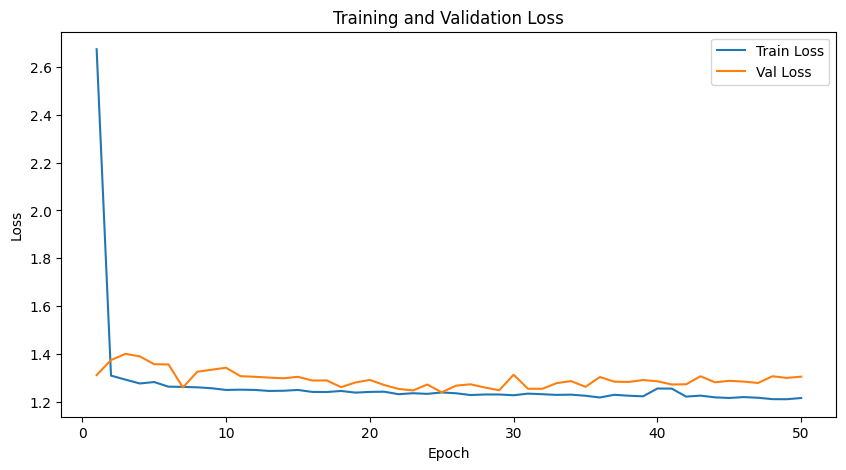

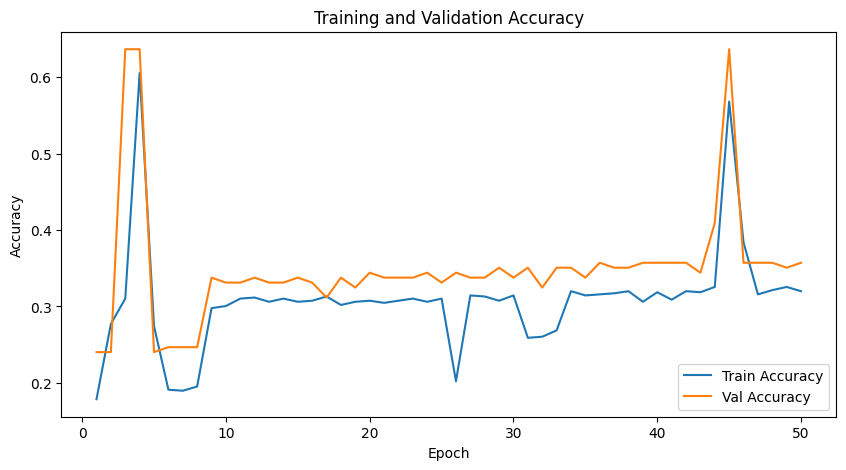

In [27]:
#model using activity data
model = SleepNet()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=64,learning_rate = 0.001, num_epochs=50,use_act=True)

Using CUDA
Epoch [1/50], Train Loss: 2.5339, Train Accuracy: 0.4404, Val Loss: 1.6598, Val Accuracy: 0.5065
Epoch [2/50], Train Loss: 1.4466, Train Accuracy: 0.6108, Val Loss: 1.3140, Val Accuracy: 0.6623
Epoch [3/50], Train Loss: 1.4122, Train Accuracy: 0.6357, Val Loss: 1.3247, Val Accuracy: 0.5844
Epoch [4/50], Train Loss: 1.3773, Train Accuracy: 0.5471, Val Loss: 1.3094, Val Accuracy: 0.6558
Epoch [5/50], Train Loss: 1.3624, Train Accuracy: 0.6330, Val Loss: 1.2787, Val Accuracy: 0.6623
Epoch [6/50], Train Loss: 1.3216, Train Accuracy: 0.6260, Val Loss: 1.2743, Val Accuracy: 0.6558
Epoch [7/50], Train Loss: 1.3035, Train Accuracy: 0.6177, Val Loss: 1.2634, Val Accuracy: 0.6494
Epoch [8/50], Train Loss: 1.2879, Train Accuracy: 0.6233, Val Loss: 1.2621, Val Accuracy: 0.6558
Epoch [9/50], Train Loss: 1.2773, Train Accuracy: 0.6233, Val Loss: 1.2616, Val Accuracy: 0.6494
Epoch [10/50], Train Loss: 1.2658, Train Accuracy: 0.6219, Val Loss: 1.2677, Val Accuracy: 0.6364
Epoch [11/50], Tra

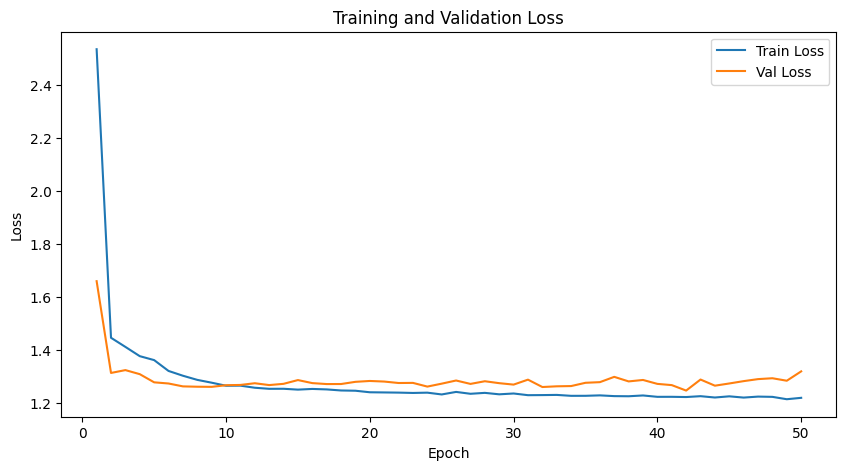

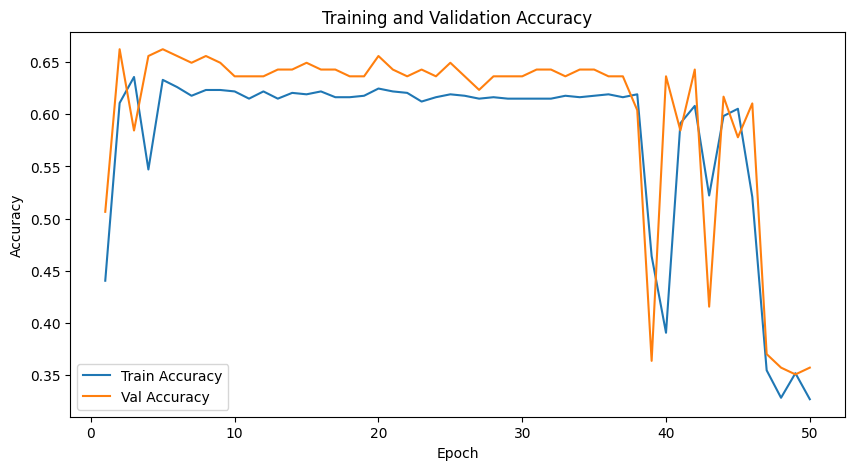

In [28]:
#model using activity data
model = SleepNet()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=64,learning_rate = 0.0005, num_epochs=50,use_act=True)

Using CUDA
Epoch [1/50], Train Loss: 1.5112, Train Accuracy: 0.2244, Val Loss: 1.2778, Val Accuracy: 0.2597
Epoch [2/50], Train Loss: 1.4104, Train Accuracy: 0.1648, Val Loss: 1.2584, Val Accuracy: 0.2468
Epoch [3/50], Train Loss: 1.3184, Train Accuracy: 0.1565, Val Loss: 1.2355, Val Accuracy: 0.2403
Epoch [4/50], Train Loss: 1.2588, Train Accuracy: 0.1662, Val Loss: 1.2623, Val Accuracy: 0.2208
Epoch [5/50], Train Loss: 1.2473, Train Accuracy: 0.1759, Val Loss: 1.2634, Val Accuracy: 0.2403
Epoch [6/50], Train Loss: 1.2541, Train Accuracy: 0.2050, Val Loss: 1.2591, Val Accuracy: 0.3377
Epoch [7/50], Train Loss: 1.2423, Train Accuracy: 0.2355, Val Loss: 1.2953, Val Accuracy: 0.2208
Epoch [8/50], Train Loss: 1.2468, Train Accuracy: 0.1814, Val Loss: 1.3087, Val Accuracy: 0.2403
Epoch [9/50], Train Loss: 1.2653, Train Accuracy: 0.2133, Val Loss: 1.2669, Val Accuracy: 0.3312
Epoch [10/50], Train Loss: 1.2494, Train Accuracy: 0.2742, Val Loss: 1.3006, Val Accuracy: 0.3182
Epoch [11/50], Tra

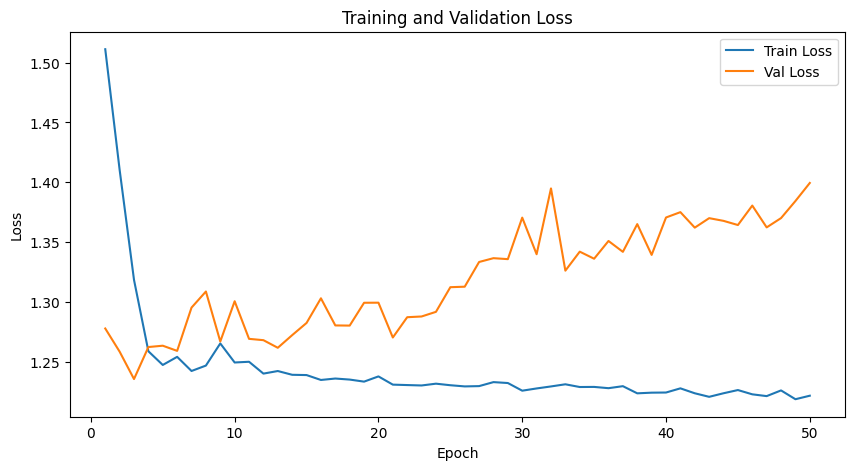

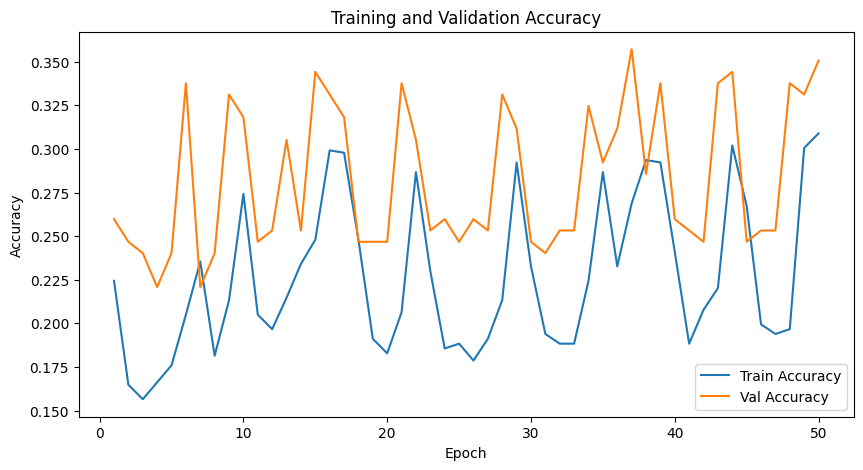

In [29]:
#model using activity data
model = SleepNet()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=128,learning_rate = 0.001, num_epochs=50,use_act=True)